In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime, os

import os
from tqdm import tqdm
import cv2

In [2]:
label_count = {'Human': 34999, 'Blank': 35000, 'Elephant_African': 34999, 'Hog_Red_River': 26069, 'Buffalo_African': 6459, 'Leopard_African': 2142, 'Monkey': 5038, 'Duiker_Blue': 35000, 'Duiker_Red': 34999, 'Porcupine_Brush_Tailed': 13694, 'Rodent': 1358, 'Squirrel': 11348, 'Rat_Giant': 34225, 'Guineafowl_Crested': 1513, 'Duiker_Yellow_Backed': 15436, 'Guineafowl_Black': 12054, 'Mongoose': 5518, 'Rail_Nkulengu': 3269, 'Chimpanzee': 5260, 'Bird': 6649, 'Genet': 3303, 'Gorilla': 1074, 'Pangolin': 872, 'Mongoose_Black_Footed': 1475, 'Mandrillus': 9305, 'Civet_African_Palm': 936, 'Chevrotain_Water': 4713, 'Cat_Golden': 406}

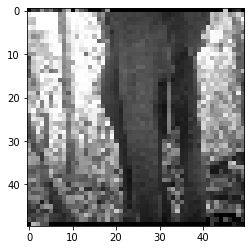

In [3]:
data = np.load("../Data/Data_Gabon/training_data_gabon.npy", allow_pickle=True)
plt.imshow(data[2][0], cmap="gray")
plt.show()

In [4]:
len(data)

347113

In [5]:
# Normalize pixel values to be between 0 and 1
for pictures in data:
    pictures[0] = pictures[0] / 255

In [6]:
# select 400 pictures of each class.
new_data = []
counter = {}
for picture in data:
#     if picture[1] == 0 or picture[1] == 1 or picture[1] == 2:
    if picture[1] == 0 or picture[1] == 2:
        if picture[1] in counter.keys():
            if counter[picture[1]] != 35000:
                new_data.append(picture)
                counter[picture[1]] += 1
            else:
                pass
        else:
            new_data.append(picture)
            counter[picture[1]] = 1
    else:
        if picture[1] in counter.keys():
            if counter[picture[1]] != 1400:
                new_data.append(picture)
                counter[picture[1]] += 1
            else:
                pass
        else:
            new_data.append(picture)
            counter[picture[1]] = 1
            
len(new_data)

104044

In [7]:
# make a set of different animals
index = 0
for item, label in new_data:
    if label > 2:
        new_data[index][1] = 1
    index += 1

In [8]:
# check labels
label_count = {}
for items, labels in new_data:
    if labels in label_count:
        label_count[labels] += 1
    else:
        label_count[labels] = 1
print(label_count)

{1: 34046, 2: 34999, 0: 34999}


In [9]:
# get the labels
def get_labels(data):
    images, labels = [], []
    for items in data:
        images.append(items[0])
        labels.append(items[1])
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

images, labels = get_labels(new_data)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [11]:
# reduce dimentions
X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)
X_val = tf.expand_dims(X_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)
y_val = tf.expand_dims(y_test, axis=-1)

In [12]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard
# %reload_ext tensorboard

In [13]:
# creating th model
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3)) # <---- change ending layers!!!

model.summary()  # summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5184)              0

In [14]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# With tensorboard
history = model.fit(X_train, y_train, epochs=4, batch_size = 32,
                    validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

# With tensorboard
# history = model.fit(X_train, y_train, epochs=10, batch_size = 32,
#                     validation_split=0.2, callbacks=[tensorboard_callback])

Epoch 1/4
1951/1951 [==============================] - 142s 72ms/step - loss: 0.6920 - accuracy: 0.6895 - val_loss: 0.4296 - val_accuracy: 0.8299
Epoch 2/4
1951/1951 [==============================] - 142s 73ms/step - loss: 0.4150 - accuracy: 0.8317 - val_loss: 0.3304 - val_accuracy: 0.8739
Epoch 3/4
1951/1951 [==============================] - 143s 73ms/step - loss: 0.3156 - accuracy: 0.8783 - val_loss: 0.2892 - val_accuracy: 0.8915
Epoch 4/4
1951/1951 [==============================] - 141s 72ms/step - loss: 0.2644 - accuracy: 0.9006 - val_loss: 0.2605 - val_accuracy: 0.9031


In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(test_acc)

651/651 [==============================] - 10s 16ms/step - loss: 0.2605 - accuracy: 0.9031
0.9031188488006592


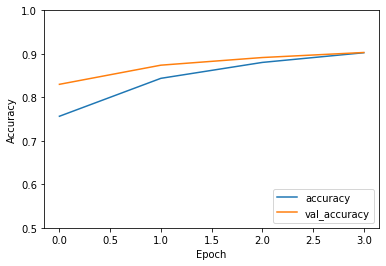

In [16]:
# launch tensorboard
# %tensorboard --logdir logs --host localhost
# %tensorboard --logdir logs 

# plot results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [17]:
# score per class
Y_test = tf.reshape(y_test, [20809])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes()
y_pred = np.argmax(model.predict(X_test), axis=-1)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6958
           1       0.92      0.91      0.91      6769
           2       0.92      0.85      0.89      7082

    accuracy                           0.90     20809
   macro avg       0.90      0.90      0.90     20809
weighted avg       0.90      0.90      0.90     20809



In [66]:
predictions = model.predict_on_batch(X_test)

In [71]:
predictions

array([[-4.333179  , -0.28341115,  3.7882288 ],
       [-3.0674586 ,  1.9085234 , -2.1482704 ],
       [-2.5868874 ,  0.16171886,  4.9923444 ],
       ...,
       [ 4.4485946 , -5.9435062 , -2.6716669 ],
       [ 3.0845265 , -2.2660155 , -1.6022667 ],
       [-3.4117131 ,  4.1332536 , -2.9804146 ]], dtype=float32)

# Test on myanmar data

0


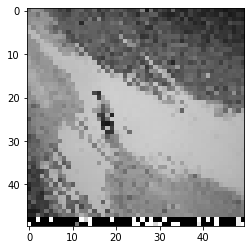

In [18]:
myanmar_data = np.load("../Data/Data_Myanmar/testing_data_myanmar_for_gabon_model.npy", allow_pickle=True)
i = 5
plt.imshow(myanmar_data[i][0], cmap="gray")
print(myanmar_data[i][1])
plt.show()

In [19]:
pictures_myan = []
labels_myan = []

# Normalize pixel values to be between 0 and 1
for pic in myanmar_data:
    pic[0] = pic[0] / 255

for picture_myan, label_myan in myanmar_data:
    pictures_myan.append(picture_myan)
    labels_myan.append(label_myan)

In [20]:
pictures_myan = np.array(pictures_myan)
labels_myan = np.array(labels_myan)

pictures_myan = tf.expand_dims(pictures_myan, axis=-1)
labels_myan = tf.expand_dims(labels_myan, axis=-1)

In [21]:
test_loss, test_acc = model.evaluate(pictures_myan, labels_myan, verbose=1)
print(test_acc)

92/92 [==============================] - 1s 16ms/step - loss: 1.6617 - accuracy: 0.3818
0.3818306028842926


In [23]:
# score per class
Y_test = tf.reshape(labels_myan, [2928])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes(pictures_myan)
np.argmax(model.predict(pictures_myan), axis=-1)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.38      0.53      2562
           1       0.07      0.44      0.12       274
           2       0.35      0.23      0.28        92

    accuracy                           0.38      2928
   macro avg       0.42      0.35      0.31      2928
weighted avg       0.76      0.38      0.48      2928



In [24]:
predictions = model.predict_on_batch(pictures_myan)

In [60]:
correct_zero, correct_one, correct_two = 0, 0, 0
for i in range(len(predictions)):
    if Y_test[i].numpy() != predictions[i].argmax():
        print("correct: " + str(Y_test[i].numpy()) + " pred: " + str(predictions[i].argmax()))
        print("---------------------")
    else:
        if Y_test[i].numpy() == 0:
            correct_zero += 1
        elif Y_test[i].numpy() == 1:
            correct_one += 1
        elif Y_test[i].numpy() == 2:
            correct_two += 1

correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 2 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred:

correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 2 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
----------------

correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred:

correct: 2 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

In [62]:
count_zero, count_one, count_two = 0, 0, 0
for label in labels_myan:
    if label == 0:
        count_zero += 1
    elif label == 1:
        count_one += 1
    elif label == 2:
        count_two += 1
print("zero " + str(count_zero) + " / " + str(correct_zero))
print("one " + str(count_one) + " / " + str(correct_one))
print("two " + str(count_two) + " / " + str(correct_two))

zero 2562 / 976
one 274 / 121
two 92 / 21
